In [1]:
using Turing
using Distances
using PyPlot
using Random
using LinearAlgebra
using LimberJack
using Interpolations

In [2]:
# Squared-exponential covariance function
sqexp_cov_fn(D, mu, phi) = @.(mu * exp(-D^2 / (2*phi))) + 0.0005 * LinearAlgebra.I
# Exponential covariance function
exp_cov_fn(D, mu, phi) = @.(mu * exp(-D / phi)) + 0.0005 * LinearAlgebra.I

exp_cov_fn (generic function with 1 method)

In [3]:
@model function marginal_GP(y, X, data_cov; cov_fn=sqexp_cov_fn, cosmology=Cosmology())
    # Dimensions of predictors .
    N, P = size(X)
    
    # Distance matrix.
    D = pairwise(Distances.Euclidean(), X, dims=1)
    
    # Priors.
    mu ~ LogNormal(0, 0.25)
    phi ~ Uniform(0.01, 3)
    
    # Realized covariance function
    K = cov_fn(D, mu, phi) #.+ data_cov
    Dz = cosmology.Dz(vec(X))
    y ~ MvNormal(Dz, K + data_cov)
end

marginal_GP (generic function with 1 method)

In [17]:
typeof(data_x)

Matrix{Float64} (alias for Array{Float64, 2})

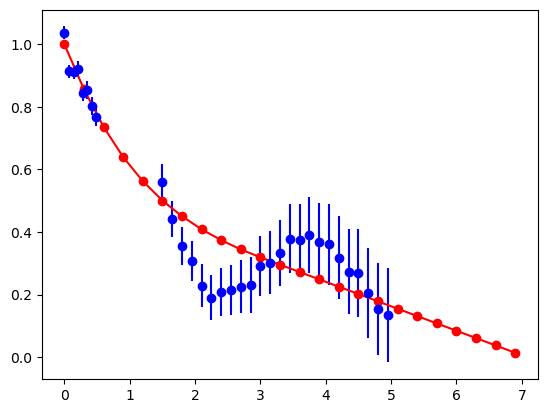

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f134d055e50>

In [16]:
cosmology = Cosmology()
data_1_x = Vector(0:0.07:0.5) 
data_2_x = Vector(1.5:0.15:5)
data_x = zeros(length(data_1_x)+length(data_2_x), 1)
data_x[1:length(data_1_x), 1] = data_1_x
data_x[length(data_1_x)+1:length(data_1_x)+length(data_2_x), 1] = data_2_x
N = length(data_x)

data = similar(vec(data_x))
data[1:length(data_1_x), 1] = cosmology.Dz(vec(data_1_x)) .* (1 .+ randn(length(data_1_x)) .* 0.03)
data[length(data_1_x)+1:length(data_1_x)+length(data_2_x), 1] = cosmology.Dz(vec(data_2_x)) .* (1 .+ 0.5 .* (sin.(vec(data_2_x)./0.5) + randn(length(data_2_x)) * 0.1))
#data = cosmology.Dz(vec(data_x)) .* (1 .+ 0.5 .* (sin.(vec(data_x)./0.5) + randn(N) * 0.1))
data_err = vec(@.((0.02 * data) + (0.03 * vec(data_x))))
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo")
gp_x = Vector(0:0.3:7)
gp_N = length(gp_x)
plt.plot(gp_x, cosmology.Dz(gp_x) .* ones(gp_N), "ro-")

In [7]:
data_cov = zeros(N, N)
for i in 1:N
    data_cov[i,i] = data_err[i]^2 
end

In [8]:
chain = sample(marginal_GP(data, data_x, data_cov), HMC(0.01, 100), 200)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


Chains MCMC chain (200×11×1 Array{Float64, 3}):

Iterations        = 1:1:200
Number of chains  = 1
Samples per chain = 200
parameters        = mu, phi
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

          mu    0.9007    0.2077     0.0147    0.0046   2760.7845    0.9955
         phi    2.0932    0.5660     0.0400    0.1278     32.2883    1.0474

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          mu    0.5887    0.7354    0.8822    1.0233    1.3255
         phi    1.0222    1.6462    2.0824    2.6072    2.9501


┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/jaime/.julia/packages/MCMCChains/kWf0l/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/jaime/.julia/packages/MCMCChains/kWf0l/src/chains.jl:364


In [9]:
mu = group(chain, :mu).value.data[:, :, 1]
phi = group(chain, :phi).value.data[:, :, 1];

In [13]:
function make_gp_predict_fn(Xnew, y, X, cov_fn, data_cov, cosmology=Cosmology())
    N = size(X, 1)
    M = size(Xnew, 1)
    Q = N + M
    Z = [Xnew; X]
    D = pairwise(Euclidean(), Z, dims=1)
    Dz = cosmology.Dz(vec(X))
    new_Dz = cosmology.Dz(vec(Xnew))
    return (mu, phi) -> let
        K = cov_fn(D, mu, phi) 
        Koo = K[(M+1):end, (M+1):end] + data_cov
        Koo_inv = inv(Koo)
        Knn = K[1:M, 1:M]
        Kno = K[1:M, (M+1):end]
        C = Kno * Koo_inv
        m = C * (y - Dz) + new_Dz
        S = Matrix(LinearAlgebra.Hermitian(Knn - C * Kno'))
        mvn = MvNormal(m, S)
        rand(mvn)
    end
end

make_gp_predict_fn (generic function with 2 methods)

In [14]:
Xnew = gp_x #sort(randn(N, 1) * 4, dims=1)
gp_predict = make_gp_predict_fn(Xnew, data, data_x, sqexp_cov_fn, data_cov)
ynew = [gp_predict(mu[m], phi[m]) for m in 1:length(mu)]
ynew = hcat(ynew...);

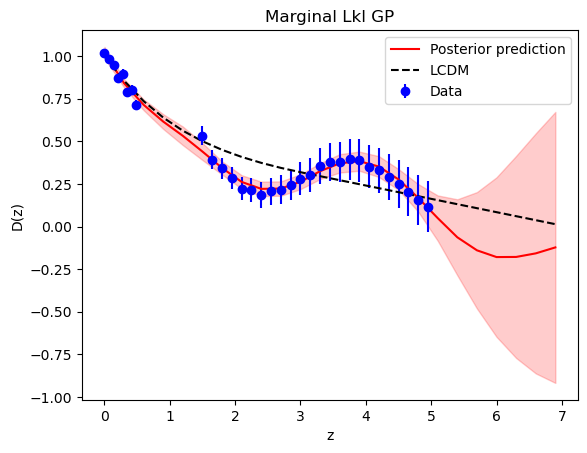

In [15]:
pred_mean = mean(ynew, dims=2)
pred_std = std(ynew, dims=2)

plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo", label="Data")
plt.plot(vec(Xnew), vec(pred_mean), color="red",
         label="Posterior prediction")
plt.fill_between(vec(Xnew), vec(pred_mean .+ pred_std),
                 vec(pred_mean .- pred_std), color="red",
                 alpha=0.2)
plt.plot(gp_x, cosmology.Dz(gp_x) .* ones(gp_N), "k--", label="LCDM")
plt.xlabel("z")
plt.ylabel("D(z)")
plt.title("Marginal Lkl GP")
plt.legend()
#plt.legend(loc="lower right")
#plt.title("GP Posterior predictive with 95% credible interval");